In [171]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

from ga import rand_nodup, not_dup
from util import pickle_load
from util import robust_z 
                                                             
import random
from deap import base, creator, tools, algorithms
from statistics import variance
from scipy.stats import norm
import pandas as pd
import numpy as np
import time
import itertools
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw

In [172]:
# validation test name
test_num = "1002"
lig = "!"

In [173]:
if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 

In [174]:
#parameter
date = 240702
num = 1
N_GEN = 1000
POP_SIZE = 100
CX_PB = 0.5
MUT_PB = 0.2
weight = (-5,1,20)
tox_scoring = "descrete"
# tox_scoring = "continuous"

In [175]:
IND_INIT_SIZE = len(val)
trys = str(date) + "_" + str(num)
memo = f"""w = {weight}, date = {date}, num = {num}, gen = {N_GEN}, pop = {POP_SIZE} IND_INIT_SIZE = {IND_INIT_SIZE}, CX_PB = {CX_PB}, MUT_PB = {MUT_PB}"""

In [176]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

# mean = np.mean(all_toxs)
# std_dev = np.std(all_toxs)
# standardized_toxs = (all_toxs - mean) / std_dev

In [177]:
if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

In [178]:
def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        mean = len(individual) / 2
        std_dev = len(individual) / 10
        toxicity_score = norm.pdf(x=count_t, loc=mean, scale=std_dev) * 1000

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [179]:
def mutSet(individual):
    for i in range(len(individual)):
        ind_list = list(individual)
        if len(ind_list) != IND_INIT_SIZE:
            return 1
        if random.random() < 1:
            n = random.randint(0,IND_INIT_SIZE-1)
            ind_list[n] = not_dup(0, len(cas_tox)-1, ind_list)
            individual = creator.Individual(ind_list) 
    return individual

In [180]:
def cxSet(ind1, ind2):
    ind_1 = list(ind1)
    ind_2 = list(ind2)
    a = random.randint(0,IND_INIT_SIZE-1)
    ind1 = ind_1[:a] + ind_2[a:]
    ind2 = ind_1[a:] + ind_2[:a]
    ind1 = creator.Individual(ind1)
    ind2 = creator.Individual(ind2)  
    return ind1, ind2

In [181]:
creator.create("Fitness", base.Fitness, weights=weight)
creator.create("Individual", set, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("attr_item", random.randint, 0, len(cas_tox)-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", multi_objective_optimization)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)
toolbox.register("select", tools.selNSGA2)

/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [182]:
def main(CX_PB, MUT_PB,IND_INIT_SIZE):
    random.seed(42)
    CX_PB = CX_PB
    MUT_PB = MUT_PB
    IND_INIT_SIZE = IND_INIT_SIZE
    tsv = []
    tsv_2 = []
    tsv_3 = []

    pop = toolbox.population(n=POP_SIZE)

    for x in range(len(pop)):
        if len(pop[x]) != IND_INIT_SIZE:
            while len(pop[x]) == IND_INIT_SIZE:
                pop[x].add(random.randint(0, len(cas_tox)-1))

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    fits = [ind.fitness.values[0] for ind in pop]

    g = 0
    while g < N_GEN:
        g = g + 1
        if g == 10:
            now = time.ctime()
            gentime = time.strptime(now)
            print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
        if g % 100 == 0:
            now = time.ctime()
            gentime = time.strptime(now)
            print(f"-------------------{g}------------------")
            print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
        offspring = toolbox.select(pop, 100)
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PB:
                child1, child2 = toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
            
            if len(child1) == IND_INIT_SIZE: 
                offspring.append(child1)
            if len(child2) == IND_INIT_SIZE:
                offspring.append(child2)

        for mutant in offspring:
            if random.random() < MUT_PB:
                mutant = toolbox.mutate(mutant)
                if mutant == 1:
                    continue
                offspring.append(mutant)

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        list_off = []
        for ind in offspring:
            list_off.append(list(ind))
        
        list_a = []
        for ind in list_off:
            if ind not in list_a:
                list_a.append(ind)
        
        li_of = []
        for ind in list_a:
            li_of.append(creator.Individual(ind))

        tsv_2.append(tools.selBest(li_of,100))

        pop[:] = offspring

        for x in range(len(pop)):
            if len(pop[x]) != IND_INIT_SIZE:
                while len(pop[x]) != IND_INIT_SIZE:
                    pop[x].add(random.randint(0, len(cas_tox)-1))
        
        col = []
        fits_0 = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits_0) / length
        sum2 = sum(x*x for x in fits_0)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        fits_1 = [ind.fitness.values[1] for ind in pop]

        length = len(pop)
        mean = sum(fits_1) / length
        sum2 = sum(x*x for x in fits_1)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        fits_2 = [ind.fitness.values[2] for ind in pop]

        length = len(pop)
        mean = sum(fits_2) / length
        sum2 = sum(x*x for x in fits_2)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        tsv.append(col)
        
        aaa = []
        for ind in pop:
            col = []
            for y in range(3):
                col.append(ind.fitness.values[y])
            aaa.append(col)
        tsv_3.append(aaa)

    best_ind = tools.selNSGA2(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    
    try:
        os.mkdir(f"../../data/result/{test_name}/GA_{trys}")
    except:
        pass
    
    pd.DataFrame(tsv).to_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None, index=False)
    pd.DataFrame(tsv_2).to_csv(f"../../data/result/{test_name}/GA_{trys}/top_5.tsv", sep="\t", header=None, index=False)
    pd.DataFrame(tsv_3).to_csv(f"../../data/result/{test_name}/GA_{trys}/data.tsv", sep="\t", header=None, index=False)
    with open(f"../../data/result/{test_name}/GA_{trys}/memo.txt", "w") as f:
        f.write(memo)

In [183]:
print(IND_INIT_SIZE)
if __name__ == "__main__":
    main(CX_PB, MUT_PB, IND_INIT_SIZE)
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime), flush=True)

16
2024/07/16 17:53
-------------------100------------------
2024/07/16 17:53
-------------------200------------------
2024/07/16 17:53
-------------------300------------------
2024/07/16 17:53
-------------------400------------------
2024/07/16 17:53
-------------------500------------------
2024/07/16 17:53
-------------------600------------------
2024/07/16 17:53
-------------------700------------------
2024/07/16 17:53
-------------------800------------------
2024/07/16 17:53
-------------------900------------------
2024/07/16 17:53
-------------------1000------------------
2024/07/16 17:53
Best individual is Individual({320, 33, 66, 37, 41, 234, 299, 430, 207, 208, 213, 246, 150, 153, 314, 223}), (5.752287775896276, 34.747678598625235, 249.33892525089544)
2024/07/16 17:53


In [184]:
pops = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/top_5.tsv", sep="\t", header=None)

In [185]:
best_pop = pops.iloc[-1,0]
best_pop = best_pop.replace("Individual(", "").replace(")", "")

In [186]:
best_pop = list(ast.literal_eval(best_pop))

In [187]:
best_score = multi_objective_optimization(best_pop)

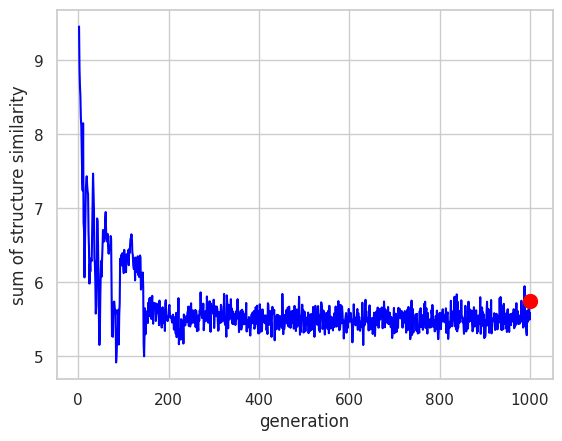

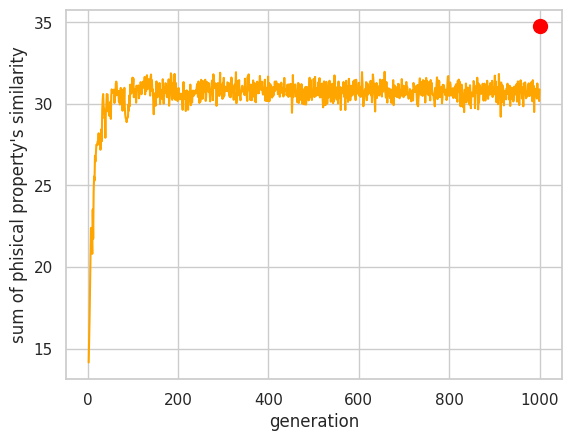

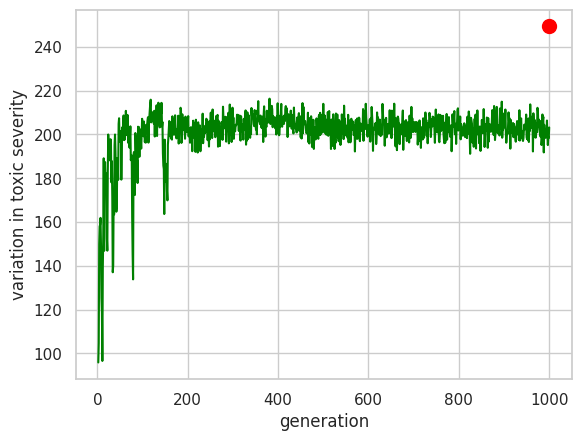

In [188]:
scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/score.tsv", sep="\t", header=None)
n = 1000
m_tani = []
s_tani = []
m_butsu = []
s_butsu = []
m_tox = []
s_tox = []
m_mw = []
s_mw = []

for i in range(1, n):
    m_tani.append(scores.iloc[i,0])
    s_tani.append(scores.iloc[i,1])
    m_butsu.append(scores.iloc[i,2])
    s_butsu.append(scores.iloc[i,3])
    m_tox.append(scores.iloc[i,4])
    s_tox.append(scores.iloc[i,5])
    #m_mw.append(scores.iloc[i,6])
    #s_mw.append(scores.iloc[i,7])

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

x = list(range(2, n+1))

fig_1 = plt.figure()
ax_1 = fig_1.add_subplot(1, 1, 1)

ax_1.plot(x, m_tani, label='similaryty of chemical structures', color= "blue")
ax_1.plot(1000, best_score[0], marker=".", color="red", markersize=20)
#ax_1.legend(prop={'family':'Yu Gothic'})
ax_1.set_xlabel("generation")
ax_1.set_ylabel("sum of structure similarity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/structure.png")

fig_2 = plt.figure()
ax_2 = fig_2.add_subplot(1, 1, 1)

#ax_1.errorbar(x, m_tani, yerr=s_tani, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
ax_2.plot(x, m_butsu, label='similarity among chemical propaties', color="orange")
ax_2.plot(1000, best_score[1], marker=".", color="red", markersize=20)
#ax_2.legend(prop={'family':'Yu Gothic'})
ax_2.set_xlabel("generation")
ax_2.set_ylabel("sum of phisical property's similarity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/phisical_property.png")
#ax_2.errorbar(x, m_butsu, yerr=s_butsu, marker='o', capthick=1, capsize=10, lw=1, alpha=0.2, color="blue")

fig_3 = plt.figure()
ax_3 = fig_3.add_subplot(1, 1, 1)

ax_3.plot(x, m_tox, label='variation in toxic severity', color="green")
ax_3.plot(1000, best_score[2], marker=".", color="red", markersize=20)
#ax_3.legend(prop={'family':'Yu Gothic'})
ax_3.set_xlabel("generation")
ax_3.set_ylabel("variation in toxic severity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/toxicity.png")
#ax_3.errorbar(x, m_tox, yerr=s_tox, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
#ax_3.plot(1000, s[2], marker=".", color="red", markersize=20)
#ax_3.errorbar(x, m_mw, yerr=s_mw, marker='o', capthick=1, capsize=10, lw=1)
plt.show()

In [189]:
init_pops = []

for i in range(len(pops.iloc[0])):
    init_pop = pops.iloc[0,i]
    init_pop = init_pop.replace("Individual(", "").replace(")", "")
    init_pop = list(ast.literal_eval(init_pop))
    scores = multi_objective_optimization(init_pop)
    if scores[0] <= 1e4:
         init_pops.append(multi_objective_optimization(init_pop))


In [190]:
last_pops = []

for i in range(len(pops.iloc[-1])):
    if type(pops.iloc[-1,i]) == str:
        last_pop = pops.iloc[-1,i]
        last_pop = last_pop.replace("Individual(", "").replace(")", "")
        last_pop = list(ast.literal_eval(last_pop))
        last_pops.append(multi_objective_optimization(last_pop))


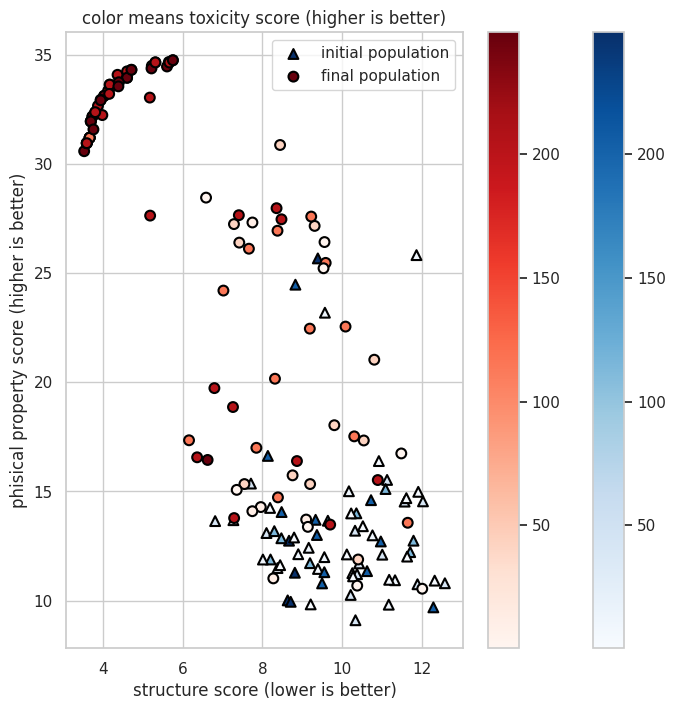

In [191]:
init_pops= np.array(init_pops)
last_pops = np.array(last_pops)

x1 = init_pops[:, 0]  
y1 = init_pops[:, 1]  
c1 = init_pops[:, 2]

x2 = last_pops[:, 0] 
y2 = last_pops[:, 1]  
c2 = last_pops[:, 2]  

vmin = min(c1.min(), c2.min())
vmax = max(c1.max(), c2.max())

fig, ax = plt.subplots(figsize=(8, 8))

sc1 = ax.scatter(x1, y1, c=c1, cmap='Blues', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='initial population', marker="^")
sc2 = ax.scatter(x2, y2, c=c2, cmap='Reds', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='final population', marker="o")
cbar1 = plt.colorbar(sc1, ax=ax)
cbar2 = plt.colorbar(sc2, ax=ax)

ax.set_xlabel('structure score (lower is better)')
ax.set_ylabel('phisical property score (higher is better)')
ax.set_title('color means toxicity score (higher is better)')

# ax.set_xlim(-0.02, 0.4)
# ax.set_ylim(-0.02, 0.6)

ax.legend()
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/palate.png")
plt.show()

In [192]:
all_smiles = []
for i in range(len(cas_tox)):
    all_smiles.append(cas_tox.iloc[i,2])
    
smiles_list = []
for i in range(len(all_smiles)):
    if i in best_pop:
        smiles_list.append(all_smiles[i])

In [193]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

In [194]:
fig = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(500, 500))
with open(f"../../data/result/{test_name}/GA_{trys}/GA_chems.png", mode='wb') as f:
    f.write(fig.data)